In [1]:
import os
import pickle
from pydrake.all import HPolyhedron


In [66]:
import os
import glob
import pickle
import numpy as np
logs_directory = 'logs_gridworld'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    b = int(name_parts[-5])
    N = int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    last_pickle_file = max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    
    # Read the last line of the text file to extract coverage
    with open(last_text_file, 'r') as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[b]:
        grouped_experiments[b][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][N].append([
            np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for data in experiment_data:
            print(f"    Experiment data: {data}")

Experiments with b = 9:
  Experiments with N = 1:
    Experiment data: [98, 0.915, 402.73087334632874]
    Experiment data: [91, 0.9221, 356.08925342559814]
    Experiment data: [93, 0.936, 374.2401146888733]
    Experiment data: [101, 0.9494, 407.50198888778687]
    Experiment data: [88, 0.9383, 338.6244044303894]
    Experiment data: [93, 0.939, 366.62996315956116]
    Experiment data: [84, 0.9345, 311.93381786346436]
    Experiment data: [90, 0.9066, 370.4370551109314]
    Experiment data: [101, 0.9148, 437.327321767807]
    Experiment data: [99, 0.91, 436.980357170105]
  Experiments with N = 300:
    Experiment data: [20, 0.9347, 63.19207692146301]
    Experiment data: [20, 0.9357, 56.87392568588257]
    Experiment data: [20, 0.9246, 57.85796141624451]
    Experiment data: [20, 0.9419, 57.76423192024231]
    Experiment data: [20, 0.9413, 58.52744388580322]
    Experiment data: [20, 0.9525, 61.27999949455261]
    Experiment data: [20, 0.9416, 61.522032499313354]
    Experiment data:

<ipython-input-66-7d7cc402e761>:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])


In [87]:
box_counts = [3,5,7,9,11]
minimum_covers = [(b+1)*2 for b in box_counts]
labels = ["N=1", "N=30", "N=300"]
fields = ['Number of Regions', 'Coverage', 'Time']
N_vals = [1,30,300]

data_1_mean = []
data_30_mean = []
data_300_mean = []
dm = [data_1_mean, data_30_mean, data_300_mean]

data_1_std = []
data_30_std = []
data_300_std = []
ds = [data_1_std, data_30_std, data_300_std]


for b in box_counts:
    exps = grouped_experiments[b]
    for N_exp in N_vals:
        runs = exps[N_exp]
        run_mean = np.mean(np.array(runs), axis = 0)
        run_std = np.std(np.array(runs), axis = 0)
        dm[N_vals.index(N_exp)].append(run_mean.tolist())
        ds[N_vals.index(N_exp)].append(run_std.tolist())

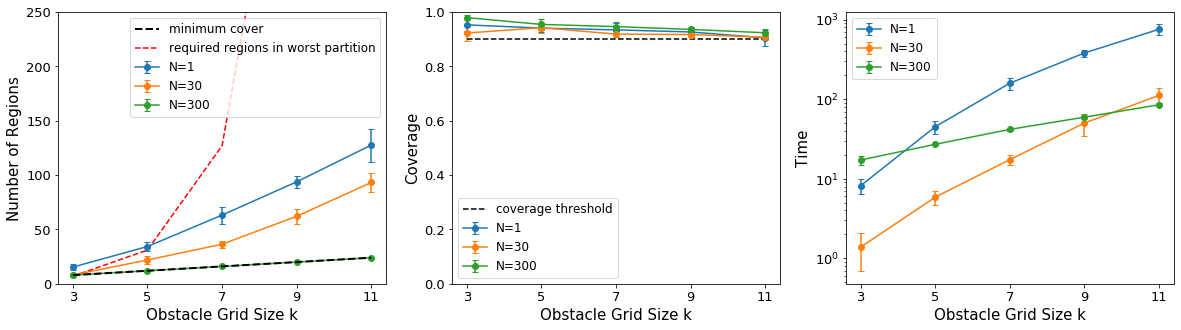

In [90]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (20,5))

for field_id, ax in enumerate(axs):
    for approach_id, (mean_approach, std_approach) in enumerate(zip(dm, ds)):
        ax.errorbar(box_counts, np.array(mean_approach)[:, field_id], yerr=np.array(std_approach)[:, field_id], fmt='o-', capsize=3, label  = labels[approach_id])
        ax.set_xlabel('Obstacle Grid Size k',fontsize =15)
        ax.set_ylabel(fields[field_id], fontsize =15)
        ax.set_xticks(box_counts)
        
    if field_id ==2:
        ax.semilogy()
    if field_id ==1:
        ax.set_ylim([0,1])
        ax.plot([3,11], [0.9,0.9], linestyle='--', c = 'k', label = 'coverage threshold')
    if field_id == 0:
        #ax.semilogy()
        ax.set_ylim([0,250])
        ax.plot(box_counts, minimum_covers, linestyle = 'dashed', c = 'k', linewidth= 2, label ='minimum cover', zorder = 8)
        ax.plot(box_counts, [2**k-1 for k in box_counts], linestyle = 'dashed', c = 'r', label ='required regions in worst partition')
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.legend(fontsize = 12)
plt.savefig('2d_grid_comparison.pdf')

done


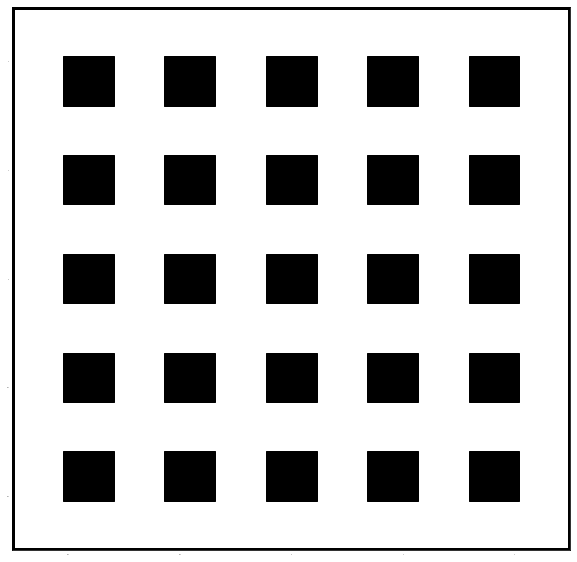

In [98]:
from gridenv import GridWorld
from seeding_utils import sorted_vertices
size = 5
dim = 2
# boxes = 9
alpha = 0.05
eps = 0.1
world = GridWorld(5, side_len=size, seed = 1)
            
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
#world.plot_cfree(ax)
from pydrake.all import HPolyhedron, VPolytope
for obs in world.obstacles:
    v = sorted_vertices(VPolytope(obs)).T
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    ax.fill(v[:,0], v[:,1], alpha = 1.0, c = 'k')
verts = sorted_vertices(VPolytope(HPolyhedron.MakeBox([-size*1.0] * dim, [size*1.0] * dim))).T
verts = np.concatenate((verts, verts[0,:].reshape(1,2)), axis = 0)
ax.plot(verts[:,0], verts[:,1],c= 'k', linewidth = 5)
plt.tick_params(axis='both', which='both', length=0, labelsize=0)
plt.savefig('grid_world.pdf')
plt.pause(0.01)

done


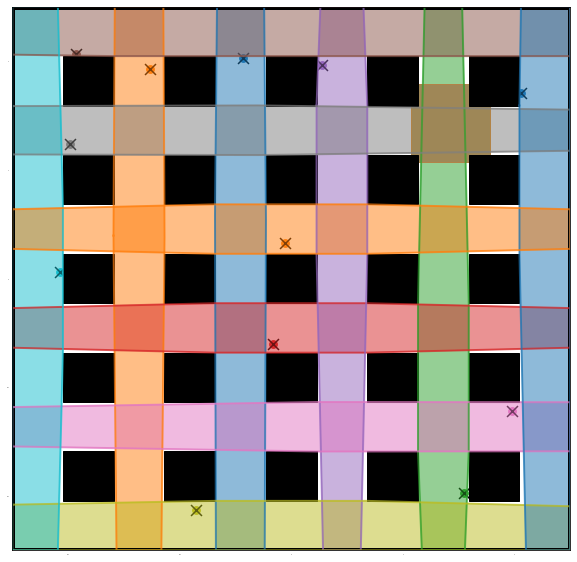

In [161]:
path = 'logs/experiment_gridworld_single_5_7_300_0.050_0.100/data/it_0.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)

regions = []

for a,b in zip(data['ra'][0], data['rb'][0]):
    regions.append(HPolyhedron(a,b))

from gridenv import GridWorld
from seeding_utils import sorted_vertices

size = 5
dim = 2
# boxes = 9
alpha = 0.05
eps = 0.1
world = GridWorld(5, side_len=size, seed = 1)
            
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
#world.plot_cfree(ax)
from pydrake.all import HPolyhedron, VPolytope

verts = sorted_vertices(VPolytope(HPolyhedron.MakeBox([-size*1.0] * dim, [size*1.0] * dim))).T
verts = np.concatenate((verts, verts[0,:].reshape(1,2)), axis = 0)
ax.plot(verts[:,0], verts[:,1],c= 'k', linewidth = 5)


for r, p in zip(regions, data['sp'][0]):
    #  p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.7)
    #     else:
    #         p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.7, c = color)
    a = ax.plot([0,0], [0,0], linewidth = 2, alpha = 0.0)
    ax.scatter(p[0], p[1], c = a[0].get_color(), s= 60)
    ax.scatter(p[0], p[1], c = 'k', marker='x', s= 120)
    ax.fill(v[:,0], v[:,1], alpha = 0.5, c = a[0].get_color())
    world.plot_HPoly(ax,r, color= a[0].get_color())

for obs in world.obstacles:
    v = sorted_vertices(VPolytope(obs)).T
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    ax.fill(v[:,0], v[:,1], alpha = 1.0, c = 'k')
plt.tick_params(axis='both', which='both', length=0, labelsize=0)
plt.savefig('grid_world2.pdf')
plt.pause(0.01)

In [162]:
p

array([-0.11088119,  0.65775506])

done


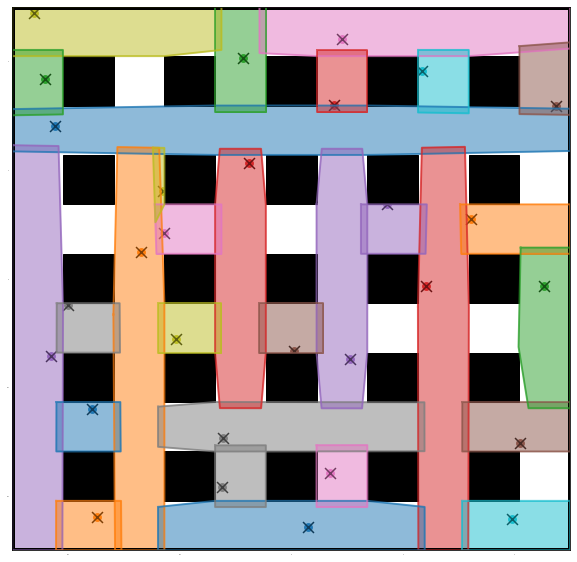

In [163]:
path = 'logs/experiment_gridworld_single_5_7_1_0.050_0.100/data/it_28.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)

regions = []

for a,b in zip(data['ra'], data['rb']):
    regions.append(HPolyhedron(a[0],b[0]))

from gridenv import GridWorld
from seeding_utils import sorted_vertices

size = 5
dim = 2
# boxes = 9
alpha = 0.05
eps = 0.1
world = GridWorld(5, side_len=size, seed = 1)
            
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
#world.plot_cfree(ax)
from pydrake.all import HPolyhedron, VPolytope

verts = sorted_vertices(VPolytope(HPolyhedron.MakeBox([-size*1.0] * dim, [size*1.0] * dim))).T
verts = np.concatenate((verts, verts[0,:].reshape(1,2)), axis = 0)
ax.plot(verts[:,0], verts[:,1],c= 'k', linewidth = 5)
sp = np.array(data['sp'])
for r,p in zip(regions,sp):
    a = ax.plot([0,0], [0,0], linewidth = 2, alpha = 0.0)
    ax.scatter(p[0], p[1], c = a[0].get_color(), s= 60)
    ax.scatter(p[0], p[1], c = 'k', marker='x', s= 120)
    ax.fill(v[:,0], v[:,1], alpha = 0.5, c = a[0].get_color())
    world.plot_HPoly(ax,r, color= a[0].get_color())

for obs in world.obstacles:
    v = sorted_vertices(VPolytope(obs)).T
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    ax.fill(v[:,0], v[:,1], alpha = 1.0, c = 'k')
plt.tick_params(axis='both', which='both', length=0, labelsize=0)
plt.savefig('grid_world3.pdf')
plt.pause(0.01)

done


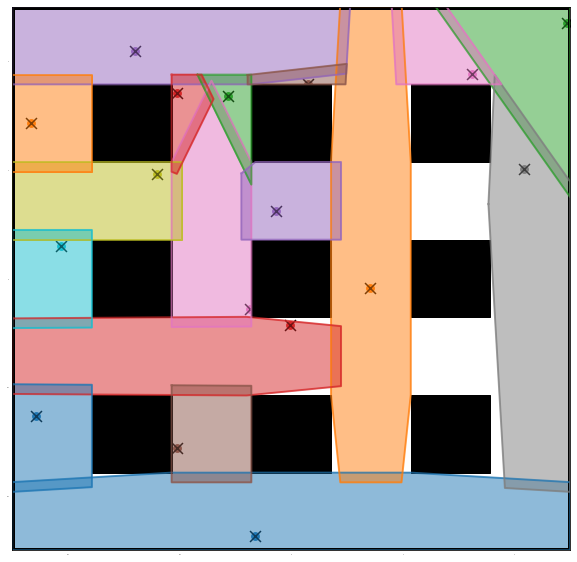

In [160]:
path = 'logs/experiment_gridworld_single_3_2_1_0.050_0.100/data/it_16.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)

regions = []

for a,b in zip(data['ra'], data['rb']):
    regions.append(HPolyhedron(a[0],b[0]))

from gridenv import GridWorld
from seeding_utils import sorted_vertices

size = 5
dim = 2
# boxes = 9
alpha = 0.05
eps = 0.1
world = GridWorld(3, side_len=size, seed = 1)
            
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
#world.plot_cfree(ax)
from pydrake.all import HPolyhedron, VPolytope


verts = sorted_vertices(VPolytope(HPolyhedron.MakeBox([-size*1.0] * dim, [size*1.0] * dim))).T
verts = np.concatenate((verts, verts[0,:].reshape(1,2)), axis = 0)
ax.plot(verts[:,0], verts[:,1],c= 'k', linewidth = 5)
sp = np.array(data['sp'])
for r,p in list(zip(regions,sp)):
    a = ax.plot([0,0], [0,0], linewidth = 2, alpha = 0.0)
    ax.scatter(p[0], p[1], c = a[0].get_color(), s= 60)
    ax.scatter(p[0], p[1], c = 'k', marker='x', s= 120)
    ax.fill(v[:,0], v[:,1], alpha = 0.5, c = a[0].get_color())
    world.plot_HPoly(ax,r, color= a[0].get_color())
for obs in world.obstacles:
    v = sorted_vertices(VPolytope(obs)).T
    v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
    ax.fill(v[:,0], v[:,1], alpha = 1.0, c = 'k')

plt.tick_params(axis='both', which='both', length=0, labelsize=0)
# plt.savefig('grid_world3.pdf')
plt.pause(0.01)

In [157]:
len(list(zip(regions,sp)))

17

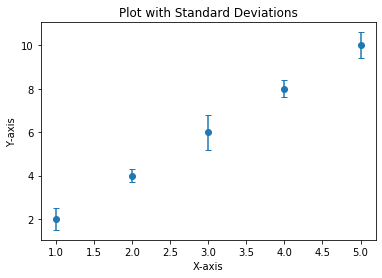

In [15]:


# Generate sample data
x = np.arange(1, 6)
y = np.array([2, 4, 6, 8, 10])
std = np.array([0.5, 0.3, 0.8, 0.4, 0.6])  # Standard deviations

# Create the plot
plt.errorbar(x, y, yerr=std, fmt='o', capsize=3)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot with Standard Deviations')

# Show the plot
plt.show()

In [ ]:
#cgshop examples


In [19]:
import os
import glob
import pickle
import numpy as np

def get_instance_name(str_parts):
    str = ''
    for p in str_parts:
        str+=p + '_'
    str = str.replace('experiment_', '')
    str = str.replace('.instance.json_', '')
    str = str.replace('00', '')
    return str

logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    instance_name = get_instance_name(name_parts[:-4])
    N = int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    last_pickle_file = max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    
    # Read the last line of the text file to extract coverage
    with open(last_text_file, 'r') as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if instance_name not in grouped_experiments:
        grouped_experiments[instance_name] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[instance_name]:
        grouped_experiments[instance_name][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[instance_name][N].append([
            np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with name = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for data in experiment_data:
            print(f"    Experiment data: {data}")

Experiments with name = cheese205:
  Experiments with N = 30:
    Experiment data: [52, 0.9196, 54.333433389663696]
    Experiment data: [56, 0.9244, 58.984628677368164]
    Experiment data: [55, 0.9199, 59.7051465511322]
  Experiments with N = 1:
    Experiment data: [51, 0.9219, 270.8358232975006]
    Experiment data: [66, 0.9511, 321.66007804870605]
    Experiment data: [47, 0.902, 245.3493094444275]
  Experiments with N = 300:
    Experiment data: [58, 0.916, 116.0337872505188]
    Experiment data: [55, 0.9005, 115.84769916534424]
    Experiment data: [66, 0.936, 123.24117374420166]
Experiments with name = fpg-poly_60_h1:
  Experiments with N = 30:
    Experiment data: [19, 0.9585, 8.882784843444824]
    Experiment data: [18, 0.9598, 9.283585786819458]
    Experiment data: [15, 0.9168, 9.262413501739502]
  Experiments with N = 300:
    Experiment data: [24, 0.9683, 30.257994890213013]
    Experiment data: [16, 0.9086, 15.606281042098999]
    Experiment data: [27, 0.9563, 32.7010958

<ipython-input-19-76d2c8763be4>:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])


In [2]:
name_parts

['experiment', 'cheese205.instance.json', '1', '30', '0.050', '0.100']

'cheese205'

KeyError: 't_tot'

In [164]:
path = 'logs/experiment_srpg_iso_aligned_mc0000172.instance.json_single_1_300_0.050_0.100/data/it_1.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)
    


done


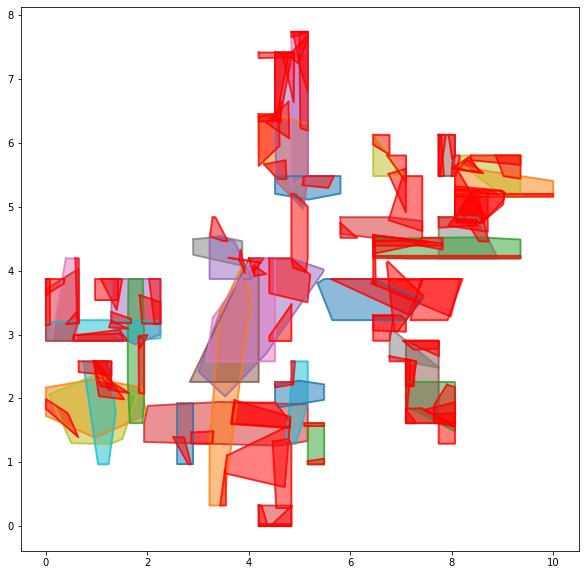

In [172]:
regions = []
id_g = []
for ga, gb in zip(data['ra'],data['rb']):
    ids = []
    for a,b in zip(ga,gb):
        ids.append(len(regions))
        regions.append(HPolyhedron(a,b)) 
    id_g.append(ids)
    
world = GridWorld(3, side_len=size, seed = 1)
fig,ax = plt.subplots(figsize = (10,10))
for r in regions[:35]:
    world.plot_HPoly(ax, r)
for r in regions[35:]:
    world.plot_HPoly(ax, r, color ='r')



In [170]:
id_g[1]

[35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134]

In [1]:
import os
import glob
import pickle
import numpy as np
logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    b = 0 if 'naive' in name_parts else -1#int(name_parts[-5])
    N = int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    last_pickle_file = max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    
    # Read the last line of the text file to extract coverage
    with open(last_text_file, 'r') as file:
        lines = file.readlines()
        last_line = lines[-2].strip()
        coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[b]:
        grouped_experiments[b][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][N].append([
            np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for datas in experiment_data:
            print(f"    Experiment data: {datas}")

Experiments with b = 0:
  Experiments with N = 1:
    Experiment data: [211, 0.785, 2879.9784038066864]
    Experiment data: [210, 0.8027, 2932.3846418857574]
    Experiment data: [221, 0.781, 3046.202001094818]
    Experiment data: [185, 0.7883, 2283.041822910309]
    Experiment data: [183, 0.8047, 2356.5532450675964]
    Experiment data: [201, 0.7973, 2890.8788261413574]
    Experiment data: [196, 0.7793, 2501.194744825363]
    Experiment data: [175, 0.801, 2197.3756189346313]
    Experiment data: [193, 0.7897, 2559.2548298835754]
    Experiment data: [205, 0.7983, 2891.203600168228]
Experiments with b = -1:
  Experiments with N = 500:
    Experiment data: [96, 0.7963, 2160.696249961853]
    Experiment data: [88, 0.7967, 2010.1744346618652]
    Experiment data: [80, 0.7927, 1600.2767539024353]
    Experiment data: [99, 0.8053, 2220.1119287014008]
    Experiment data: [83, 0.801, 1552.5705614089966]
    Experiment data: [94, 0.7927, 2347.846934080124]
    Experiment data: [77, 0.79, 1

<ipython-input-1-2e7eeee71b1b>:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), coverage , data['ttotal']])


In [3]:
data = np.array(grouped_experiments[-1][500])
mean = data.mean(axis=0)
std = data.std(axis=0)
print(f"regs {mean[0]:.1f} t {mean[2]:.1f}")
print(f"regs {std[0]:.1f} t {std[2]:.1f}")

regs 88.9 t 1885.6
regs 6.9 t 339.2


In [10]:
experiment_data[0][1]

0.785

In [18]:
data.keys()

dict_keys(['vg', 'vad', 'sp', 'ra', 'rb', 'coverage', 'tstep', 'tsample', 'ttotal'])